In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Based on the WFDB to read databased: https://wfdb.readthedocs.io/en/latest/io.html

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys, os
import wfdb
import pywt

In [2]:
from collections import Counter
from PIL import Image
from PIL import ImageOps

Download the MIT-BIH database using the WFDB to read databased: https://wfdb.readthedocs.io/en/latest/io.html

DATABASE DOWNLOAD
========

In [3]:
wfdb.io.dl_database('mitdb', './mitbih')

Finished downloading files


Plot a record to observe the raw data

In [18]:
record = wfdb.io.rdrecord('./100', sampto=3000)
annotation = wfdb.io.rdann('./100', 'atr', sampto=3000)

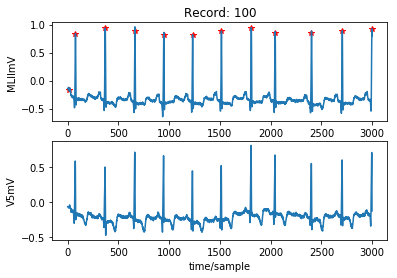

In [21]:
wfdb.plot_wfdb(record=record, annotation=annotation)

The following code to transform MIT-BIH annotation data into 2D images is based on the https://github.com/Lorne0/ECG_Deep, mainly from the  preprocess_2D.py function in that code.

In [4]:
data_names_DS1 = ['101','106', '108', '109', '112', '114', '115', '116', 
                  '118', '119', '122', '124', '201', '203', '205', '207',
                  '208', '209', '215', '220', '223', '230']
data_names_DS2 = ['100', '103', '105', '111', '113', '117', '121', '123',
                  '200', '202', '210', '212', '213', '214', '219', '221', 
                  '222', '228', '231', '232', '233', '234']

In [ ]:
labels = ['N', 'S', 'V', 'F', 'Q']
sub_labels = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']
sub = {'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N', 
        'A':'S', 'a':'S', 'J':'S', 'S':'S',
        'V':'V', 'E':'V',
        'F':'F',
        '/':'Q', 'f':'Q', 'Q':'Q'}

The data division above has been proposed for inter-patient analysis on the following paper (so that heartbeats from the same patient are not part of training and testing sets): 

*Mar, T., Zaunseder, S., Mart&#x00ED;nez, J. P., Llamedo, M., & Poll, R. (2011)*. **Optimization of ECG Classification by Means of Feature Selection**. *IEEE Transactions on Biomedical Engineering, 58, 2168–2177.* https://doi.org/10.1109/TBME.2011.2113395

Let's read the dataset from the mentioned datasets (this should be run twice, with DS1 and DS2):

In [7]:
X = []
Y = []
for d in data_names_DS2:
    r=wfdb.rdrecord('./mitbih/'+d)
    ann=wfdb.rdann('./mitbih/'+d, 'atr', return_label_elements=['label_store', 'symbol'])        
    sig = np.array(r.p_signal[:,0])
    sig_len = len(sig)
    sym = ann.symbol        
    pos = ann.sample
    beat_len = len(sym)
    for i in range(1,beat_len-1):
        if sym[i] in sub_labels: 
            if (pos[i]-pos[i-1])>200 and (pos[i+1]-pos[i])>200:
                a = sig[pos[i]-150:pos[i]+150]
                a, cD3, cD2, cD1 = pywt.wavedec(a, 'db6', level=3)
                X.append(a)
                Y.append(labels.index(sub[sym[i]]))

In [8]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
print(Counter(Y))

_X_train = X
Y_train = Y

print(_X_train.shape)
print(Counter(Y_train))

(39473, 47)
(39473,)
Counter({0: 37332, 1: 1438, 2: 617, 3: 81, 4: 5})
(39473, 47)
Counter({0: 37332, 1: 1438, 2: 617, 3: 81, 4: 5})


# Change 1D signal to 2D image

In [ ]:
# Change 1D signal to 2D image
x = list(range(X.shape[1]))
cnt = 0

X_train = None
for i in range(len(_X_train)):
    a = _X_train[i]
    plt.clf()
    plt.figure(figsize=(2.24,2.24), dpi= 100)   # So the output has size 224 x 224 pixels
    plt.plot(x,a)    
    plt.axis('off')
    fn =  labels[Y[i]]+str(i)+'.png'    
    plt.savefig('./DS2/'+labels[Y[i]]+'/'+fn)    
    plt.close()
    cnt += 1
    if cnt%1000==0:
        print(cnt)

# CLASSIFY DATASET

Run rom here if the dataset is already downloaded

In [11]:
from fastai import *
from fastai.vision import *

In [25]:
path = '/home/tanis/repos/ECG_Deep/'
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224)
data.normalize(mnist_stats)

In [36]:
path

'/home/tanis/repos/ECG_Deep/'

In [32]:
data.show_batch(rows=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [30]:
print(data.classes)
len(data.classes),data.c

['F', 'N', 'Q', 'S', 'V']


(5, 5)

In [34]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)